<a href="https://colab.research.google.com/github/cryingjin/Today-I-learned/blob/master/RUS_EDA_PreProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 반도체 공정 데이터를 사용한 박막의 두께 광 스펙트럼 분석  
data : https://dacon.io/competitions/official/235554/overview/

### <span style="color:red"> 데이터 설명  
데이콘에 있는 데이터 설명  

__구조 설명__  
이번 대회에서 분석할 소자는 질화규소(layer_1)/이산화규소(layer_2)/질화규소(layer_3)/이산화규소(layer_4)/규소(기판) 총 5층 구조로 되어 있습니다. 대회의 목적은 기판인 규소를 제외한 layer_1 ~ layer_4의 두께를 예측하는 것으로 train.csv 파일에는 각 층의 두께와 반사율 스펙트럼이 포함되어 있습니다. 

__데이터 설명__  
train.csv 파일에는 4층 박막의 두께와 파장에 따른 반사율 스펙트럼이 주어집니다.   
헤더의 이름에 따라 layer_1 ~ 4는 해당 박막의 두께,
0부터 225은 빛의 파장에 해당하는 반사율이 됩니다.  
헤더 이름인 0부터 225은 파장을 뜻하며 비식별화 처리가 되어있어 실제 값과는 다릅니다.

## Ready

In [ ]:
# ready
import pandas as pd
import numpy as np
import glob
import json
from tqdm import tqdm

# visualize modules 

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette("hls")
pd.set_option('display.max_columns', 999) # 컬럼갯수
import warnings
warnings.filterwarnings('ignore')
# plt.style.use('ggplot') 더 예쁜 seaborn 사용
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'     # 한글 폰트 설정

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# colab - google drive 연결
%cd /content/drive/'My Drive'/RUS

/content/drive/My Drive/RUS


## 1. Load Data  
- train.csv
- test.csv

In [ ]:
ls

data/  RUS_EDA_PreProcessing.ipynb


In [ ]:
train = pd.read_csv('/content/drive/My Drive/RUS/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/RUS/data/test.csv')

In [ ]:
# 확인
print(train.shape)     # 81만개
print(test.shape)    # 1만개
train.head(10)

(810000, 230)
(10000, 227)


,layer_1,layer_2,layer_3,layer_4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
0,10,10,10,10,0.254551,0.258823,0.254659,0.252085,0.247678,0.253614,0.246511,0.259407,0.260862,0.242524,0.253870,0.245156,0.245548,0.255501,0.228948,0.228632,0.225802,0.249418,0.246910,0.248747,0.251088,0.244886,0.233906,0.242632,0.221792,0.236521,0.220555,0.243761,0.230202,0.226122,0.220671,0.235075,0.224560,0.226998,0.209499,0.226594,0.225476,0.224669,0.233551,0.224695,0.214059,0.215451,0.222333,0.202142,0.219397,0.218482,0.203569,0.200052,0.204668,0.205163,0.210409,0.205481,0.221073,0.193407,0.195662,0.193293,0.207151,0.194120,0.199404,0.191580,0.187853,0.185392,0.200859,0.184270,0.185017,0.189149,0.201704,0.178829,0.200114,0.176768,0.202258,0.185935,0.200251,0.188061,0.191104,0.169006,0.175374,0.169496,0.173800,0.167452,0.172431,0.174298,0.162710,0.180574,0.175767,0.165693,0.172443,0.158489,0.172004,0.181759,0.162470,0.172063,0.155012,0.171733,0.158018,0.153949,0.165214,0.147266,0.170829,0.145234,0.164719,0.151643,0.164846,0.170996,0.148866,0.158070,0.157883,0.156614,0.145529,0.167061,0.151388,0.162956,0.158071,0.145496,0.160881,0.148179,0.162632,0.153460,0.162362,0.156548,0.157694,0.151111,0.164965,0.155728,0.149260,0.154921,0.138105,0.147493,0.159195,0.148970,0.159782,0.155037,0.147596,0.154287,0.164378,0.167029,0.168657,0.173257,0.175540,0.169369,0.184006,0.169240,0.172977,0.188885,0.188956,0.188983,0.168166,0.188366,0.178189,0.183270,0.154747,0.174022,0.151023,0.163006,0.144926,0.163576,0.159313,0.149224,0.141561,0.128726,0.145124,0.135836,0.143166,0.146841,0.149541,0.145434,0.119599,0.129756,0.140655,0.123685,0.134774,0.121456,0.126664,0.122108,0.146444,0.130366,0.135187,0.153986,0.148589,0.130125,0.136006,0.151720,0.152425,0.144325,0.167494,0.160129,0.160126,0.164192,0.171406,0.162364,0.168591,0.166626,0.169696,0.196383,0.194145,0.190646,0.186797,0.191748,0.190886,0.208518,0.211220,0.229286,0.226265,0.226954,0.229023,0.237112,0.262421,0.262566,0.272062,0.292049,0.305353,0.292889,0.317479,0.316911,0.321371,0.355636,0.354750,0.369223,0.388184,0.408496,0.414564,0.429403,0.419225,0.443250,0.433414,0.465502
1,10,10,10,20,0.205062,0.225544,0.217758,0.202169,0.199633,0.207380,0.191318,0.195369,0.200536,0.197588,0.198726,0.191803,0.199625,0.206465,0.182836,0.193341,0.180459,0.196416,0.185398,0.188913,0.176011,0.173457,0.182249,0.176816,0.192716,0.185924,0.183816,0.186900,0.161040,0.173525,0.172948,0.182634,0.161153,0.158073,0.152335,0.148293,0.173913,0.164630,0.166498,0.149946,0.157480,0.140385,0.151373,0.164423,0.159819,0.142183,0.159111,0.135754,0.155538,0.153764,0.147988,0.141430,0.147157,0.128320,0.143349,0.134982,0.115491,0.123907,0.116343,0.139515,0.122887,0.121952,0.124709,0.115172,0.106789,0.125669,0.105336,0.113389,0.103389,0.098193,0.119512,0.121378,0.119641,0.116655,0.111344,0.096858,0.088048,0.096452,0.089945,0.085686,0.082047,0.100776,0.078251,0.099588,0.079823,0.076646,0.075789,0.091981,0.078182,0.082409,0.085509,0.093576,0.088663,0.074196,0.069241,0.066174,0.072723,0.070791,0.075919,0.082080,0.081874,0.069062,0.071412,0.065123,0.082904,0.060860,0.079682,0.081916,0.081820,0.066513,0.070069,0.076625,0.067492,0.070690,0.066154,0.074697,0.063112,0.086417,0.065787,0.079910,0.074906,0.084334,0.097133,0.08

In [ ]:
test.head()     # id 컬럼 포함

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
0,0,0.535410,0.520775,0.494087,0.465134,0.430339,0.401751,0.355986,0.326427,0.282340,0.216756,0.181081,0.128061,0.090104,0.071084,0.027930,0.025360,0.035067,0.084959,0.119919,0.167098,0.219223,0.264180,0.303416,0.359825,0.383026,0.437603,0.457129,0.511524,0.525033,0.544154,0.558287,0.588944,0.591619,0.604344,0.594368,0.616329,0.617499,0.616428,0.622483,0.608188,0.589408,0.579811,0.572689,0.535276,0.531884,0.506720,0.463794,0.428374,0.397188,0.358233,0.320985,0.271494,0.241959,0.170666,0.133295,0.097977,0.088037,0.062212,0.066572,0.069299,0.086092,0.111821,0.160620,0.180033,0.217358,0.257005,0.302687,0.309737,0.357228,0.356120,0.399767,0.397478,0.421747,0.415379,0.420101,0.395504,0.395155,0.378241,0.367109,0.340878,0.321535,0.294862,0.251011,0.233811,0.192675,0.147237,0.122587,0.084800,0.085742,0.097255,0.095726,0.138646,0.168029,0.240509,0.287566,0.345314,0.416404,0.454278,0.528662,0.548380,0.607686,0.629263,0.672402,0.704309,0.704186,0.732075,0.747648,0.759551,0.759334,0.789642,0.780827,0.797476,0.795992,0.785202,0.800730,0.786542,0.797836,0.783744,0.785836,0.771139,0.761042,0.740651,0.737801,0.708574,0.678409,0.656223,0.606936,0.579049,0.548710,0.492235,0.453975,0.399819,0.346249,0.314887,0.299802,0.293525,0.303287,0.331058,0.367460,0.402818,0.461104,0.488451,0.530605,0.580132,0.608629,0.631929,0.630750,0.666776,0.668374,0.681298,0.656742,0.676088,0.649166,0.653360,0.624414,0.627899,0.603772,0.568674,0.530422,0.481103,0.455072,0.398145,0.354418,0.305315,0.257106,0.208718,0.150469,0.144564,0.158061,0.161681,0.208233,0.240214,0.295370,0.341098,0.413017,0.439993,0.482450,0.533209,0.554202,0.556905,0.578959,0.606174,0.613974,0.608783,0.630806,0.618124,0.608499,0.598381,0.586389,0.552573,0.527883,0.488114,0.445729,0.418668,0.354205,0.280794,0.201839,0.131517,0.062330,0.028610,0.008230,0.036909,0.076047,0.141627,0.219861,0.305271,0.402317,0.465201,0.527406,0.590492,0.637339,0.649940,0.692388,0.703576,0.714609,0.750994,0.748339,0.757575,0.768130,0.777062,0.769173,0.768253,0.738704,0.739460,0.702139,0.702238
1,1,0.351099,0.398179,0.413809,0.418529,0.433257,0.455410,0.451065,0.464230,0.476011,0.477219,0.480153,0.472766,0.477897,0.479871,0.449263,0.450770,0.426963,0.430181,0.404833,0.392706,0.363237,0.343717,0.335713,0.314341,0.315998,0.297495,0.287035,0.285863,0.260355,0.278014,0.287343,0.311354,0.308082,0.326284,0.344012,0.364763,0.415674,0.431457,0.457605,0.464115,0.493231,0.495945,0.524833,0.553802,0.563072,0.557222,0.583854,0.568150,0.593560,0.595349,0.591010,0.583719,0.586454,0.562245,0.569383,0.550440,0.517482,0.509301,0.481702,0.481169,0.436910,0.404312,0.371222,0.321732,0.269649,0.241872,0.173532,0.134474,0.081277,0.040317,0.036955,0.028315,0.032036,0.050546,0.080932,0.113121,0.158131,0.223743,0.274684,0.325786,0.374019,0.440192,0.460344,0.519596,0.533244,0.559256,0.583691,0.621637,0.626404,0.646338,0.662477,0.681132,0.684532,0.676257,0.675456,0.674547,0.681279,0.677541,0.678834,0.679028,0.670592,0.647120,0.636174,0.613718,0.612165,0.567306,0.559505,0.531014,0.495852,0.441048,0.400873,0.360074,0.301190,0.254231,0.201824,0.168437,0.124694,0.128963,0.104490,0.130171,0.150546,0.195963,0.251567,0.289690,0.319199,0.376656,0.422724,0.462960,0.502195

## 2. Data EDA  
각 컬럼별 특징을 살펴보겠습니다  
dacon pipe line 도 참고 : https://dacon.io/competitions/official/235554/codeshare/1260?page=1&dtype=recent&ptype=pub

### 2.1 NA 확인

In [ ]:
train.columns

Index(['layer_1', 'layer_2', 'layer_3', 'layer_4', '0', '1', '2', '3', '4',
       '5',
       ...
       '216', '217', '218', '219', '220', '221', '222', '223', '224', '225'],
      dtype='object', length=230)

In [ ]:
# 각 컬럼별 기술통계 확인
train.describe()

,layer_1,layer_2,layer_3,layer_4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
count,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810000.000000,810

In [ ]:
# NA 확인
train.isnull().sum()     # 없음

layer_1    0
layer_2    0
layer_3    0
layer_4    0
0          0
          ..
221        0
222        0
223        0
224        0
225        0
Length: 230, dtype: int64

### 2.2 연속형 변수의 histogram 확인

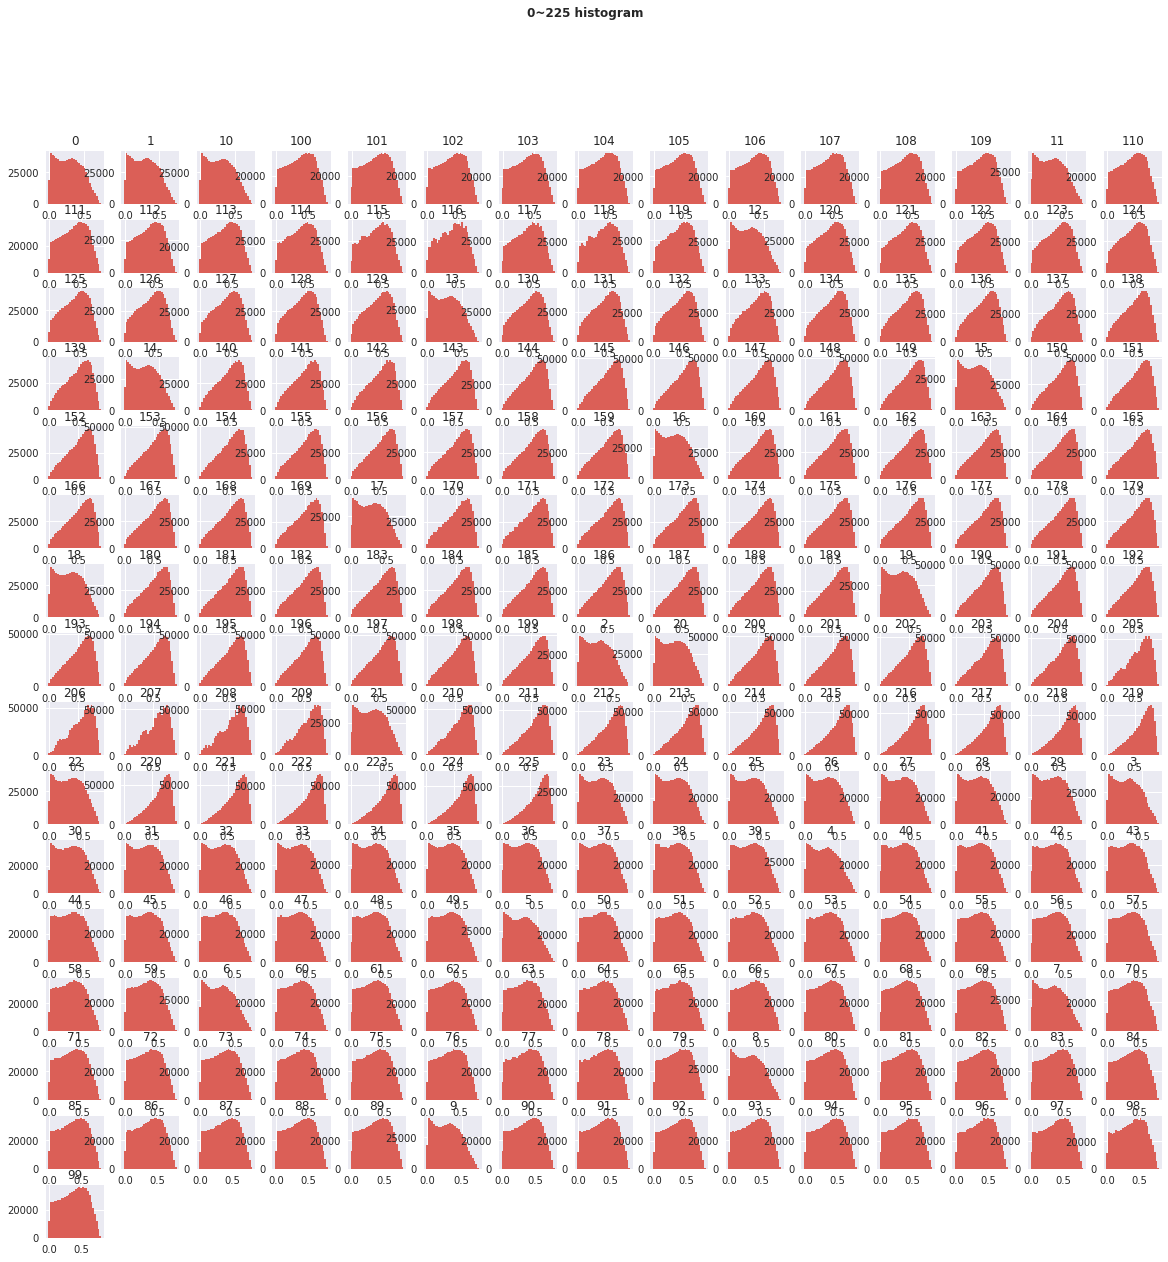

In [ ]:
# 규소 0~225의 histogram 확인
g = train.iloc[:,4:].hist(bins=30,figsize=(20,20))
plt.suptitle("0~225 histogram", ha='center',fontweight=800)
plt.show()

### 2.3 각 layer 1 ~ 4 의 분포 및 상관관계 확인

In [ ]:
train.iloc[:,:4]

,layer_1,layer_2,layer_3,layer_4
0,10,10,10,10
1,10,10,10,20
2,10,10,10,30
3,10,10,10,40
4,10,10,10,50
...,...,...,...,...
809995,300,300,300,260
809996,300,300,300,270
809997,300,300,300,280
809998,300,300,300,290


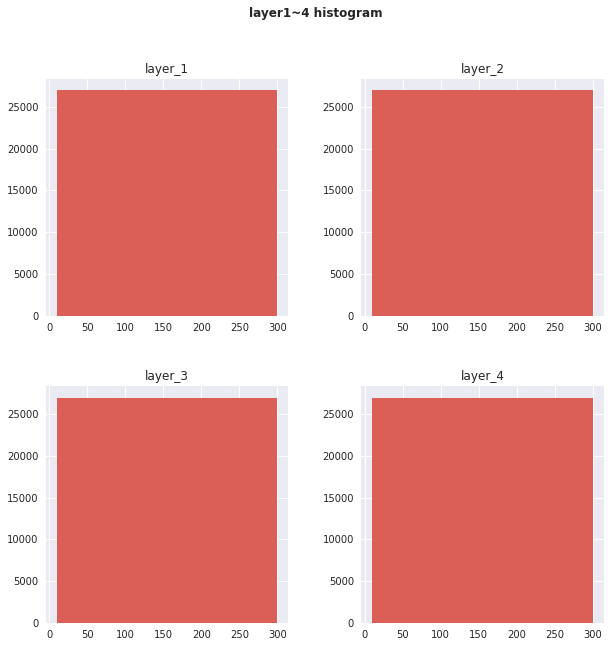

In [ ]:
# target 인 layer1~4의  histogram 확인
g = train.iloc[:,:4].hist(bins=30,figsize=(10,10))
plt.suptitle("layer1~4 histogram", ha='center',fontweight=800)
plt.show()

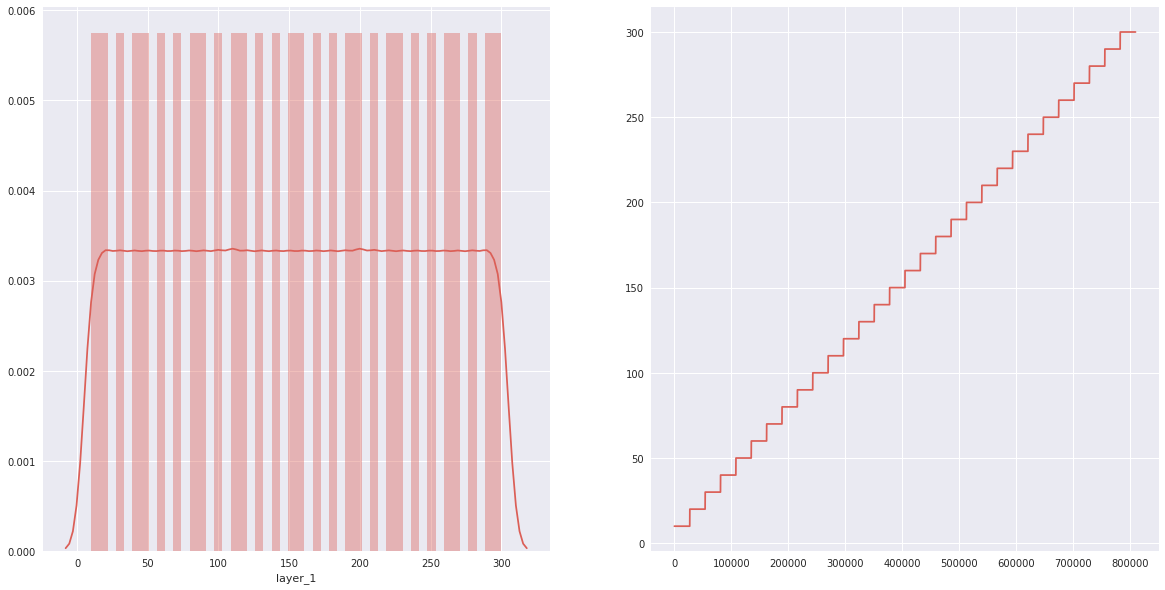

In [ ]:
# target - layer_1
f, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,10))

# distplot
ax[0] = plt.subplot(1,2,1)
ax[0] = sns.distplot(train['layer_1'])
# plot
ax[1] = plt.subplot(1,2,2)
ax[1]= plt.plot(train['layer_1'])

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


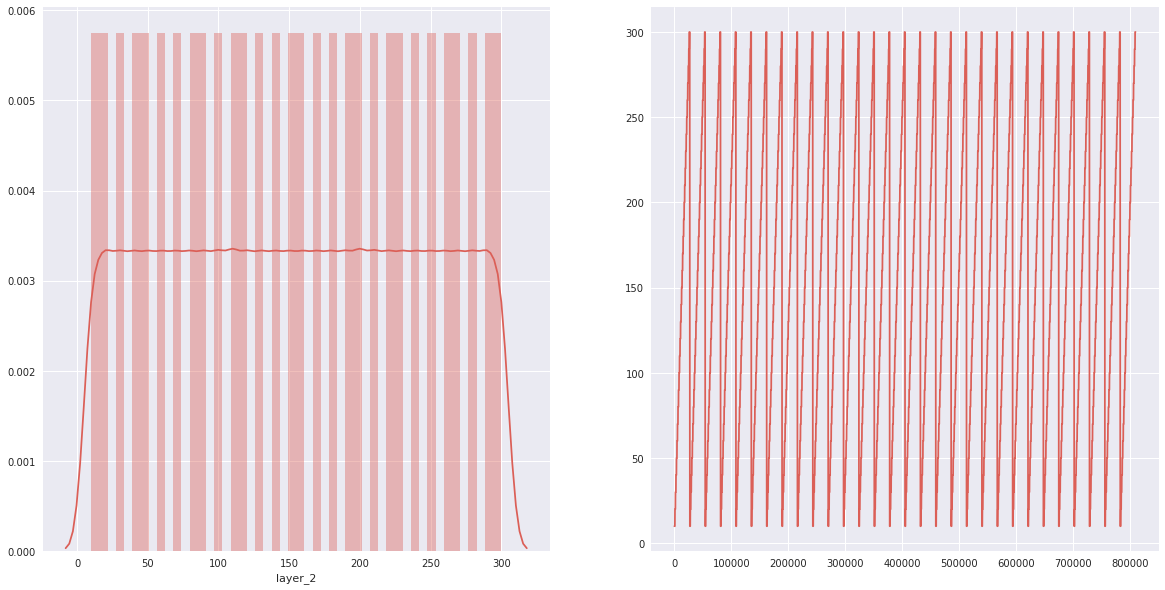

In [ ]:
# target - layer_2
f, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,10))

# distplot
ax[0] = plt.subplot(1,2,1)
ax[0] = sns.distplot(train['layer_2'])
# plot
ax[1] = plt.subplot(1,2,2)
ax[1]= plt.plot(train['layer_2'])

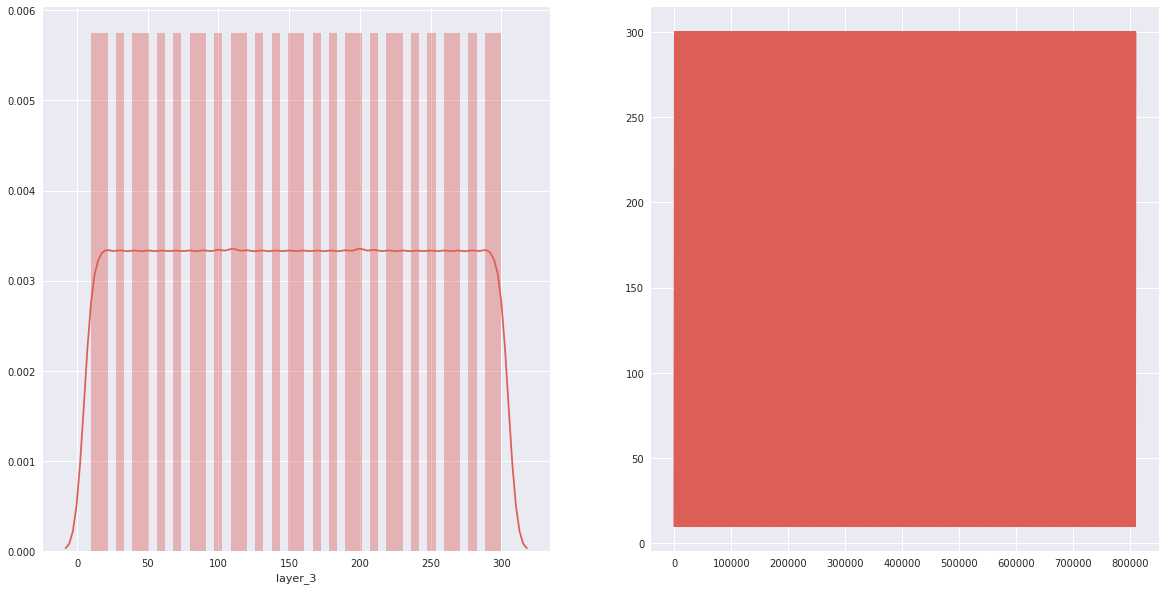

In [ ]:
# target - layer_3
f, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,10))

# distplot
ax[0] = plt.subplot(1,2,1)
ax[0] = sns.distplot(train['layer_3'])
# plot
ax[1] = plt.subplot(1,2,2)
ax[1]= plt.plot(train['layer_3'])

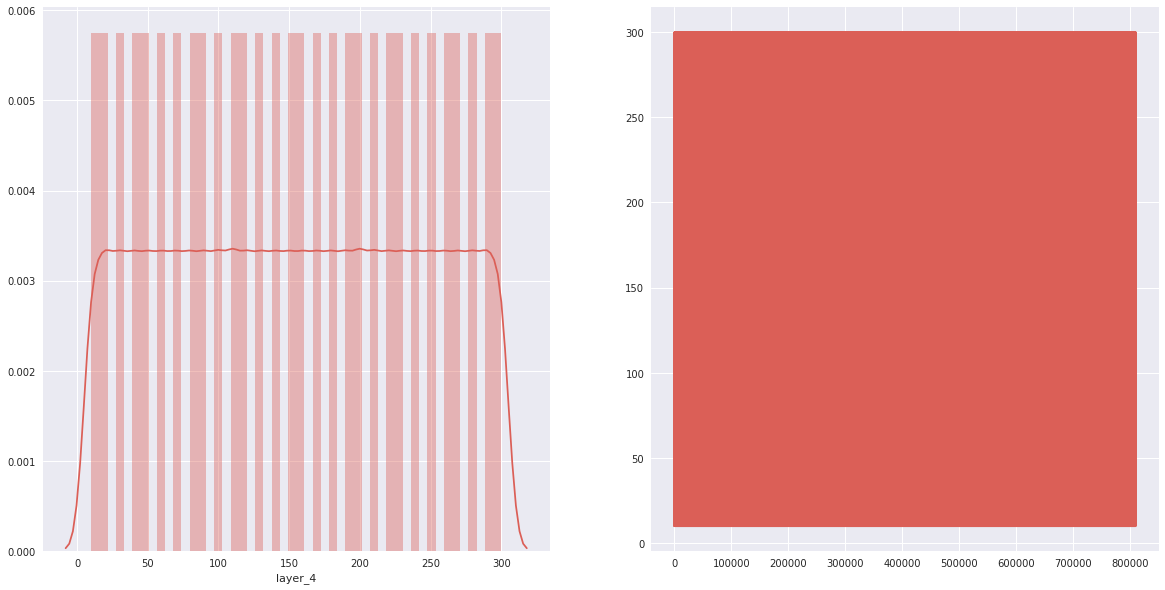

In [ ]:
# target - layer_4
f, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,10))

# distplot
ax[0] = plt.subplot(1,2,1)
ax[0] = sns.distplot(train['layer_4'])
# plot
ax[1] = plt.subplot(1,2,2)
ax[1]= plt.plot(train['layer_4'])

layer 컬럼들의 시각화 결과 0부터 300까지 이산적으로 분포함을 알 수 있다.  
또한 1,2번 레이어는 3,4 번 레이어와 다르게 분포 갯수도 일정하지 않다.  
아래의 레이어별 히트맵에서 자세히 볼 수 있다.  

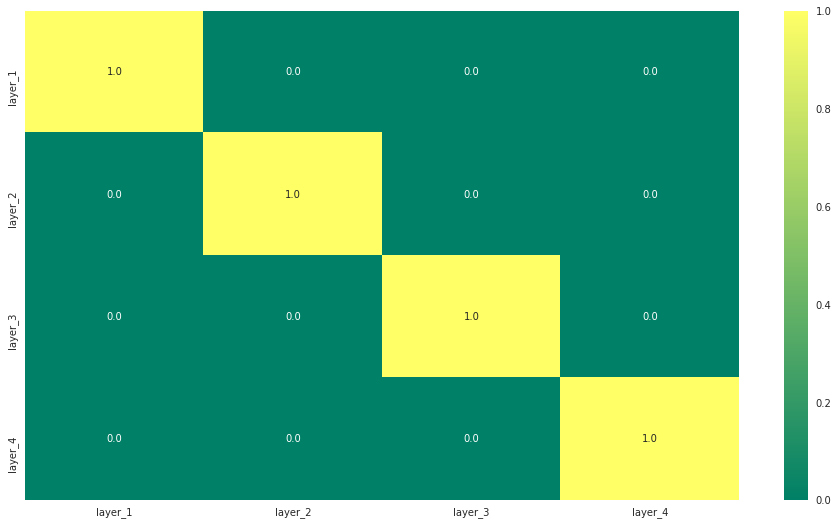

In [ ]:
# layyer_1 ~ 4 간의 상관관계 확인
plt.figure(figsize=(16,9))
sns.heatmap(train.iloc[:,:4].corr(),cmap='summer',annot=True,fmt="0.1f")
plt.show()

target 인 layer끼리는 상관관계가 전혀 없음

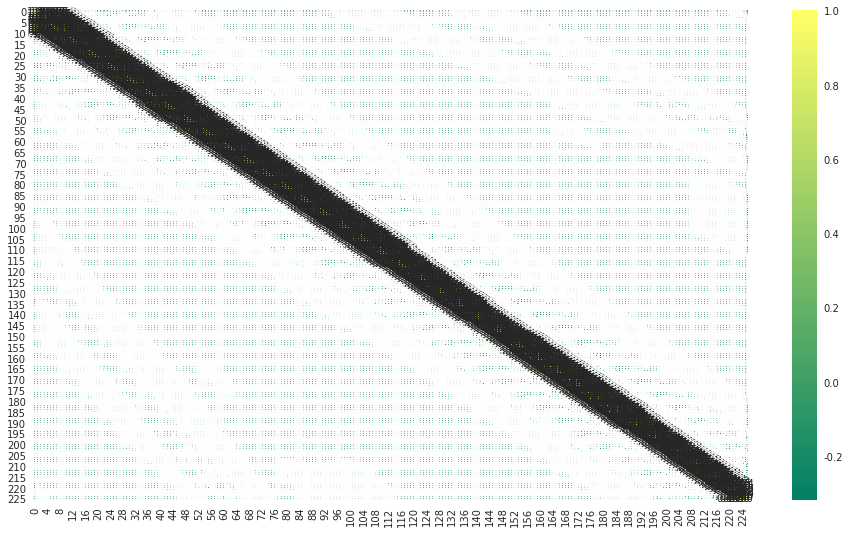

In [ ]:
# 규소 0~250 간의 상관관계 확인
plt.figure(figsize=(16,9))
sns.heatmap(train.iloc[:,4:].corr(),cmap='summer',annot=True,fmt="0.1f")
plt.show()

규소 0~250 을 히트맵 그려보면, 일정한 패턴은 보이지만 정확하게 어떤 패턴이라고 단정지을 수는 없고 이산적으로 나타나는 것만 확실히 알 수 있었다.  

### 2.4 특정 파장번호의 반사율값 확인 & 레이어의 클래스 확인 
특정 파장을 샘플 추출해서 살펴보았다.  
레이어 1~4가 discrete 한 값을 가지므로 각 클래스 값을 살펴보았다.

In [ ]:
# 100번째 파장번호의 반사율값을 확인.
wave_100_df = train.iloc[:,104:105]
wave_100_df

,100
0,0.164719
1,0.081874
2,0.066248
3,0.117332
4,0.214727
...,...
809995,0.457425
809996,0.313204
809997,0.148089
809998,0.026731


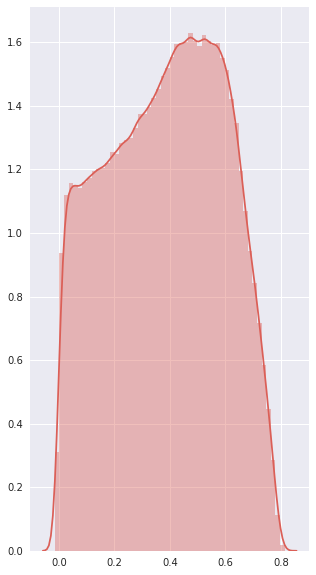

In [ ]:
# 히스토그램 분포 그려보기.
sns.distplot(wave_100_df, kde=True) # 커널밀도
plt.show()

wave_100은 0에서 0.8 사이의 굴절율을 가짐.

In [ ]:
# 4개의 레이어가 모두 동일하게 각각 10을 단위로 10~ 300까지 30가지의 경우수를 가짐.
# train의 크기가 81만 row를 가짐.(30 * 30 * 30 * 30)
print(train['layer_1'].unique())
print(train['layer_2'].unique())
print(train['layer_3'].unique())
print(train['layer_4'].unique())

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300]
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300]
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300]
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300]


#### 정리
- 4개의 레이어가 모두 동일하게 각각 10을 단위로 10~ 300까지 30가지의 경우수를 가짐.
- train의 크기가 81만 row를 가짐.(30 * 30 * 30 * 30)  

즉, layer1,2,3,4 를 맞추는데 각 layer의 클래스는 30가지 10부터 300 중에 한 가지로 맞추면 됨.

### 2.5 샘플데이터 추출 : 같은 레이어에 대해서 집계  
레이어 별로 규소 앞번호 부분과 뒷부분 으로 나눠서 반사율을 알아보기

In [ ]:
# layer_1 : 0~10
layer1_sample_df_head = train[['layer_1','0','1','2','3','4','5','6','7','8','9','10']] # , '220', '221', '222','223','224','225']
layer1_sample_df_head.head()

,layer_1,0,1,2,3,4,5,6,7,8,9,10
0,10,0.254551,0.258823,0.254659,0.252085,0.247678,0.253614,0.246511,0.259407,0.260862,0.242524,0.253870
1,10,0.205062,0.225544,0.217758,0.202169,0.199633,0.207380,0.191318,0.195369,0.200536,0.197588,0.198726
2,10,0.189196,0.165869,0.177655,0.156822,0.175094,0.177755,0.157582,0.158885,0.156911,0.166162,0.148831
3,10,0.131003,0.120076,0.138975,0.117931,0.130566,0.131262,0.126962,0.134453,0.106717,0.127309,0.099958
4,10,0.091033,0.086893,0.108125,0.080405,0.105917,0.077083,0.097895,0.086765,0.078676,0.075729,0.086023


In [ ]:
# layer1의 두께별로 반사율값을 평균치 집계
layer1_sample_df_head_agg = layer1_sample_df_head.groupby('layer_1').agg('mean')
layer1_sample_df_head_agg.head()

,0,1,2,3,4,5,6,7,8,9,10
layer_1,,,,,,,,,,,
10,0.235445,0.235704,0.235760,0.235902,0.236068,0.236278,0.236528,0.236722,0.237170,0.237520,0.237659
20,0.244268,0.244486,0.244490,0.244654,0.244835,0.244967,0.245203,0.245433,0.245785,0.246013,0.246272
30,0.257980,0.258073,0.258292,0.258369,0.258518,0.258748,0.258881,0.259243,0.259681,0.259994,0.260231
40,0.274421,0.274604,0.274882,0.275071,0.275263,0.275498,0.275808,0.276241,0.276693,0.277083,0.277484
50,0.292036,0.292293,0.292454,0.292815,0.293173,0.293405,0.293730,0.294250,0.294816,0.295265,0.295646


layer_1 : 규소 0~10 을 사용할 때는 두께 10부터 50까지 있었고, 반사율의 평균치는 규소 번호 0번 부터 10번까지 다음과 같았습니다. 

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


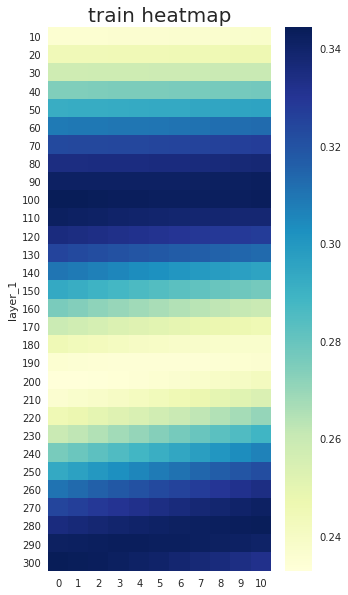

In [ ]:
# 상관관계 히트맵으로 시각화
plt.rcParams["figure.figsize"] = (5,10)
sns.heatmap(layer1_sample_df_head_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap', fontsize=20)
plt.show()

- x : 파장넘버, y: 박막 두께.
- 파장 0,1에 대해layer_1의 박막두께에 따른 평균적인 반사율값.
- 박막두께가 100, 300 (남색) 에서 높은 반사율.  
- 10, 200 (연노랑색)에서는 낮은 반사율을 보여줌.

In [ ]:
# layer_1 : 220 ~ 225 5개
layer1_sample_df_tail = train[['layer_1','220', '221', '222','223','224','225']]
layer1_sample_df_tail_agg = layer1_sample_df_tail.groupby('layer_1').agg('mean')
layer1_sample_df_tail_agg.head()

,220,221,222,223,224,225
layer_1,,,,,,
10,0.610002,0.611474,0.613349,0.615339,0.617666,0.620359
20,0.631198,0.632584,0.634421,0.636297,0.638500,0.640889
30,0.645329,0.646682,0.648273,0.649987,0.651973,0.654331
40,0.642863,0.643956,0.645377,0.647059,0.648747,0.651042
50,0.625175,0.626232,0.627653,0.629224,0.631003,0.633199


뒷부분 220-225 의 두께는 각 10,20,30,40,50 의 클래스를 가지고 각 반사율 평균은 위와 같음  

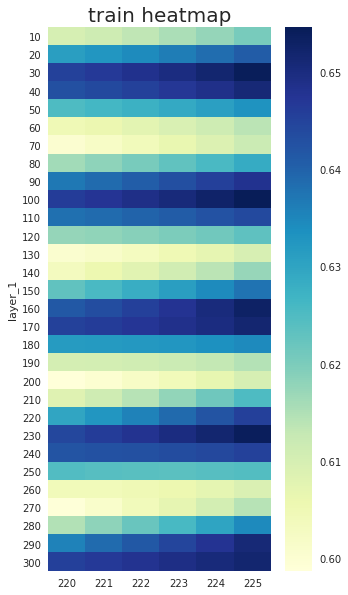

In [ ]:
# 상관관계 히트맵으로 시각화
plt.rcParams["figure.figsize"] = (5,10)
sns.heatmap(layer1_sample_df_tail_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap', fontsize=20)
plt.show()

- 40,40,100,160,170,230,240,290,300 에서 높은 반사율을 가짐, 레이어 두께가 약 70을 간격으로 나타남.  


### 인사이트 도출이 전반적으로 어렵습니다ㅠㅠ

### layer2 ~ 4 도 동일하게 확인
처음 분포 확인시, 1,2의 분포가 다르고 3,4 의 분포가 달랐음.
확인하면서 연습

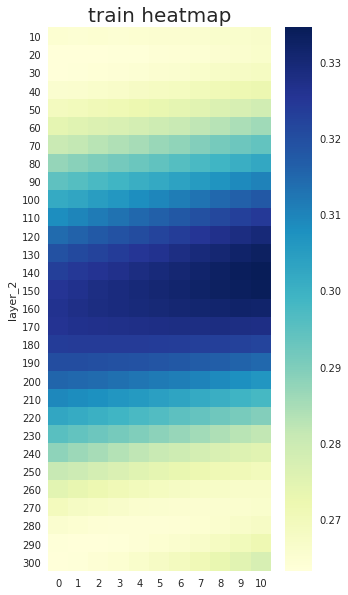

In [ ]:
# layer_2 : 0~10
layer2_sample_df_head = train[['layer_2','0','1','2','3','4','5','6','7','8','9','10']] # , '220', '221', '222','223','224','225']

# layer1의 두께별로 반사율값을 평균치 집계
layer2_sample_df_head_agg = layer2_sample_df_head.groupby('layer_2').agg('mean')

# 상관관계 히트맵으로 시각화
plt.rcParams["figure.figsize"] = (5,10)
sns.heatmap(layer2_sample_df_head_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap', fontsize=20)
plt.show()

160 +- 80 으로 반사율이 높고 이외에는 낮다

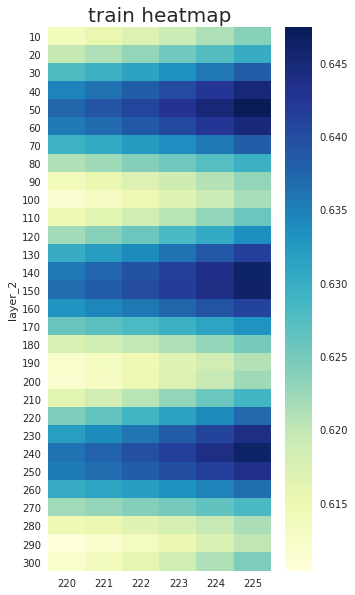

In [ ]:
# layer_2 : 220 ~ 225
layer2_sample_df_tail = train[['layer_2','220', '221', '222','223','224','225']]

# layer2의 두께별로 반사율값을 평균치 집계
layer2_sample_df_tail_agg = layer2_sample_df_tail.groupby('layer_2').agg('mean')

# 상관관계 히트맵으로 시각화
plt.rcParams["figure.figsize"] = (5,10)
sns.heatmap(layer2_sample_df_tail_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap', fontsize=20)
plt.show()

약 100 간격으로 반사율이 반복되면서 나타남

Text(0.5, 1.0, 'train heatmap tail')

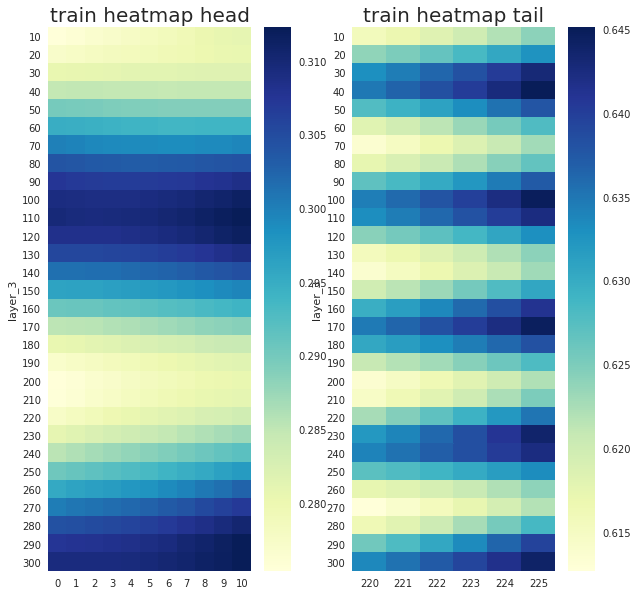

In [ ]:
# layer_3 : 0~10 & 200 ~ 225
layer3_sample_df_head = train[['layer_3','0','1','2','3','4','5','6','7','8','9','10']] # , '220', '221', '222','223','224','225']
layer3_sample_df_tail = train[['layer_3','220', '221', '222','223','224','225']]

# layer3의 두께별로 반사율값을 평균치 집계
layer3_sample_df_head_agg = layer3_sample_df_head.groupby('layer_3').agg('mean')
layer3_sample_df_tail_agg = layer3_sample_df_tail.groupby('layer_3').agg('mean')

# target - layer_3
f, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,10))

ax[0] = plt.subplot(1,2,1)
ax[0] = sns.heatmap(layer3_sample_df_head_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap head', fontsize=20)

ax[1] = plt.subplot(1,2,2)
ax[1] = sns.heatmap(layer3_sample_df_tail_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap tail', fontsize=20)

layer3도 비슷한 양상이 나타남, tail 은 반사율이 반복

Text(0.5, 1.0, 'train heatmap tail')

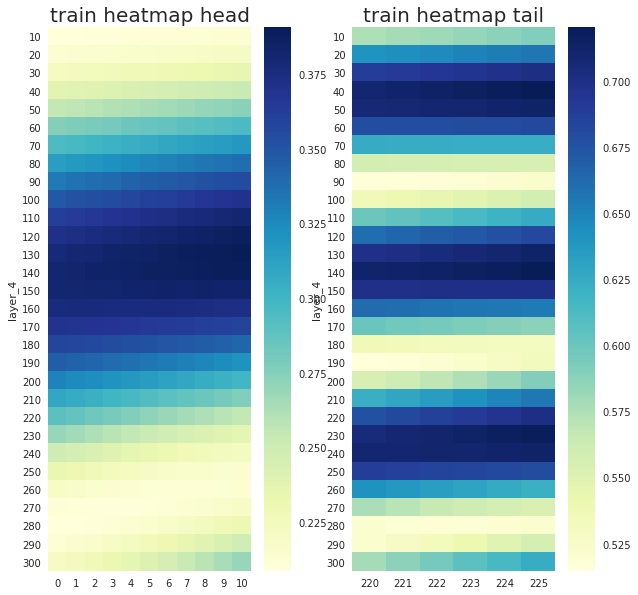

In [ ]:
# layer_4 : 0~10 & 200 ~ 225
layer4_sample_df_head = train[['layer_4','0','1','2','3','4','5','6','7','8','9','10']] # , '220', '221', '222','223','224','225']
layer4_sample_df_tail = train[['layer_4','220', '221', '222','223','224','225']]

# layer3의 두께별로 반사율값을 평균치 집계
layer4_sample_df_head_agg = layer4_sample_df_head.groupby('layer_4').agg('mean')
layer4_sample_df_tail_agg = layer4_sample_df_tail.groupby('layer_4').agg('mean')

# target - layer_4
f, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,10))

ax[0] = plt.subplot(1,2,1)
ax[0] = sns.heatmap(layer4_sample_df_head_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap head', fontsize=20)

ax[1] = plt.subplot(1,2,2)
ax[1] = sns.heatmap(layer4_sample_df_tail_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap tail', fontsize=20)

head 쪽의 반사율과 tail 쪽의 반사율은 상관관계 스케일이 다름 head쪽은 반사율이 0.3 근방에 분포하지만, tail 쪽은 0.6 정도의 높은 반사율을 보임

#### 0번부터 225번까지 한번에 보기

In [ ]:
train_layer4 = train.iloc[:,3:4]
train_rf = train.iloc[:,4:]
layer4_sample_df_all = pd.concat([train_layer4,train_rf], axis=1)
layer4_sample_df_all

,layer_4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
0,10,0.254551,0.258823,0.254659,0.252085,0.247678,0.253614,0.246511,0.259407,0.260862,0.242524,0.253870,0.245156,0.245548,0.255501,0.228948,0.228632,0.225802,0.249418,0.246910,0.248747,0.251088,0.244886,0.233906,0.242632,0.221792,0.236521,0.220555,0.243761,0.230202,0.226122,0.220671,0.235075,0.224560,0.226998,0.209499,0.226594,0.225476,0.224669,0.233551,0.224695,0.214059,0.215451,0.222333,0.202142,0.219397,0.218482,0.203569,0.200052,0.204668,0.205163,0.210409,0.205481,0.221073,0.193407,0.195662,0.193293,0.207151,0.194120,0.199404,0.191580,0.187853,0.185392,0.200859,0.184270,0.185017,0.189149,0.201704,0.178829,0.200114,0.176768,0.202258,0.185935,0.200251,0.188061,0.191104,0.169006,0.175374,0.169496,0.173800,0.167452,0.172431,0.174298,0.162710,0.180574,0.175767,0.165693,0.172443,0.158489,0.172004,0.181759,0.162470,0.172063,0.155012,0.171733,0.158018,0.153949,0.165214,0.147266,0.170829,0.145234,0.164719,0.151643,0.164846,0.170996,0.148866,0.158070,0.157883,0.156614,0.145529,0.167061,0.151388,0.162956,0.158071,0.145496,0.160881,0.148179,0.162632,0.153460,0.162362,0.156548,0.157694,0.151111,0.164965,0.155728,0.149260,0.154921,0.138105,0.147493,0.159195,0.148970,0.159782,0.155037,0.147596,0.154287,0.164378,0.167029,0.168657,0.173257,0.175540,0.169369,0.184006,0.169240,0.172977,0.188885,0.188956,0.188983,0.168166,0.188366,0.178189,0.183270,0.154747,0.174022,0.151023,0.163006,0.144926,0.163576,0.159313,0.149224,0.141561,0.128726,0.145124,0.135836,0.143166,0.146841,0.149541,0.145434,0.119599,0.129756,0.140655,0.123685,0.134774,0.121456,0.126664,0.122108,0.146444,0.130366,0.135187,0.153986,0.148589,0.130125,0.136006,0.151720,0.152425,0.144325,0.167494,0.160129,0.160126,0.164192,0.171406,0.162364,0.168591,0.166626,0.169696,0.196383,0.194145,0.190646,0.186797,0.191748,0.190886,0.208518,0.211220,0.229286,0.226265,0.226954,0.229023,0.237112,0.262421,0.262566,0.272062,0.292049,0.305353,0.292889,0.317479,0.316911,0.321371,0.355636,0.354750,0.369223,0.388184,0.408496,0.414564,0.429403,0.419225,0.443250,0.433414,0.465502
1,20,0.205062,0.225544,0.217758,0.202169,0.199633,0.207380,0.191318,0.195369,0.200536,0.197588,0.198726,0.191803,0.199625,0.206465,0.182836,0.193341,0.180459,0.196416,0.185398,0.188913,0.176011,0.173457,0.182249,0.176816,0.192716,0.185924,0.183816,0.186900,0.161040,0.173525,0.172948,0.182634,0.161153,0.158073,0.152335,0.148293,0.173913,0.164630,0.166498,0.149946,0.157480,0.140385,0.151373,0.164423,0.159819,0.142183,0.159111,0.135754,0.155538,0.153764,0.147988,0.141430,0.147157,0.128320,0.143349,0.134982,0.115491,0.123907,0.116343,0.139515,0.122887,0.121952,0.124709,0.115172,0.106789,0.125669,0.105336,0.113389,0.103389,0.098193,0.119512,0.121378,0.119641,0.116655,0.111344,0.096858,0.088048,0.096452,0.089945,0.085686,0.082047,0.100776,0.078251,0.099588,0.079823,0.076646,0.075789,0.091981,0.078182,0.082409,0.085509,0.093576,0.088663,0.074196,0.069241,0.066174,0.072723,0.070791,0.075919,0.082080,0.081874,0.069062,0.071412,0.065123,0.082904,0.060860,0.079682,0.081916,0.081820,0.066513,0.070069,0.076625,0.067492,0.070690,0.066154,0.074697,0.063112,0.086417,0.065787,0.079910,0.074906,0.084334,0.097133,0.089288,0.072687,0.086073,0.090991,0.094408,0

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


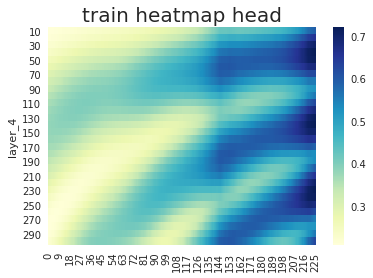

In [ ]:
# layer4의 두께별로 반사율값을 평균치 집계
layer4_sample_df_all_agg = layer4_sample_df_all.groupby('layer_4').agg('mean')

# target - layer_4
sns.heatmap(layer4_sample_df_all_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap head', fontsize=20)
plt.show()

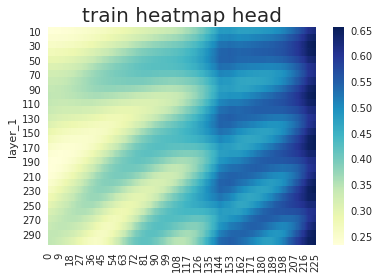

In [ ]:
# layer1, 0~225번
train_layer1 = train.iloc[:,0:1]
train_rf = train.iloc[:,4:]
layer1_sample_df_all = pd.concat([train_layer1,train_rf], axis=1)

# layer1의 두께별로 반사율값을 평균치 집계
layer1_sample_df_all_agg = layer1_sample_df_all.groupby('layer_1').agg('mean')

# target - layer_1
sns.heatmap(layer1_sample_df_all_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap head', fontsize=20)
plt.show()

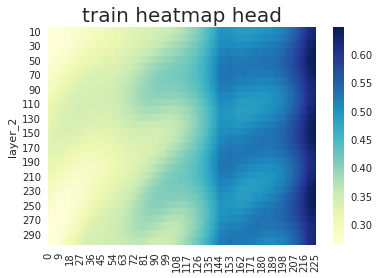

In [ ]:
# layer2, 0~225번
train_layer2 = train.iloc[:,1:2]
train_rf = train.iloc[:,4:]
layer2_sample_df_all = pd.concat([train_layer2,train_rf], axis=1)

# layer2의 두께별로 반사율값을 평균치 집계
layer2_sample_df_all_agg = layer2_sample_df_all.groupby('layer_2').agg('mean')

# target - layer_2
sns.heatmap(layer2_sample_df_all_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap head', fontsize=20)
plt.show()

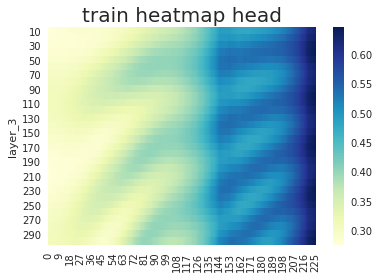

In [ ]:
# layer3, 0~225번
train_layer3 = train.iloc[:,2:3]
train_rf = train.iloc[:,4:]
layer3_sample_df_all = pd.concat([train_layer3,train_rf], axis=1)

# layer2의 두께별로 반사율값을 평균치 집계
layer3_sample_df_all_agg = layer3_sample_df_all.groupby('layer_3').agg('mean')

# target - layer_2
sns.heatmap(layer3_sample_df_all_agg, cmap='YlGnBu') # , ax=ax)
plt.title('train heatmap head', fontsize=20)
plt.show()

각 레이어가 특정 번호를 기준으로 패턴을 바뀌는 현상을 볼 수 있음

### 2.6 Feature Engineering  
- ref : https://dacon.io/competitions/official/235554/codeshare/1260?page=1&dtype=recent&ptype=pub
- Melting : https://rfriend.tistory.com/278  
- feature : wavenumber(파장번호), reflect_ratio(반사율)  
- label : layer1,2,3,4 각 두께값

In [ ]:
layer1_melt_df = pd.melt(layer1_sample_df_all, id_vars=['layer_1'],
                        var_name='wave', value_name='reflect_ratio')
layer1_melt_df

,layer_1,wave,reflect_ratio
0,10,0,0.254551
1,10,0,0.205062
2,10,0,0.189196
3,10,0,0.131003
4,10,0,0.091033
...,...,...,...
183059995,300,225,0.837526
183059996,300,225,0.702266
183059997,300,225,0.383782
183059998,300,225,0.129502


In [ ]:
# 한번에 반사율 멜팅
train_melting_df = pd.melt(train, id_vars=['layer_1','layer_2','layer_3','layer_4'],
                        var_name='wavenumber', value_name='reflect_ratio')
train_melting_df.head()

,layer_1,layer_2,layer_3,layer_4,wavenumber,reflect_ratio
0,10,10,10,10,0,0.254551
1,10,10,10,20,0,0.205062
2,10,10,10,30,0,0.189196
3,10,10,10,40,0,0.131003
4,10,10,10,50,0,0.091033


In [ ]:
# 각 레이어별로 평균적인 wavenumber별 반사율의 평균 집계값
layer1_df = train_melting_df[['layer_1','wavenumber','reflect_ratio']]
layer2_df = train_melting_df[['layer_2','wavenumber','reflect_ratio']]
layer3_df = train_melting_df[['layer_3','wavenumber','reflect_ratio']]
layer4_df = train_melting_df[['layer_4','wavenumber','reflect_ratio']]

In [ ]:
#layer1_agg = layer1_df.groupby(['layer_1','wavenumber']).agg('mean')

In [ ]:
#layer1_agg.info()

In [ ]:
#layer1_df.set_index('layer_1')